### <span style="color:brown">Notebook Instructions</span>

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i>  Assuming, you have Anaconda or some Python environment installed on your system, <span style="color:#FFFF00; background:#00C000"> <b> you need to install Keras library. </b>. </i>
- <i> <span style="color:#00C000"> RNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>


### <span style="color:brown">Data Pre- Processing</span>

In this block of code we have downalaoded the data and scaled it, just as we did in the DNN model.

In [60]:
from nsepy import get_history
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

start = date(2015,1,1)
end= date.today()

data = get_history(symbol="SBIN", start=start, end=end)

max_=data[['Open','High','Low','Close']].max().max()
min_=data[['Open','High','Low','Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X2=scl.fit_transform(data[['Volume']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2018-06-27,SBIN,EQ,267.40,0.586555,0.586555,0.555282,261.05,0.558729,263.58,0.054548,4.290454e+14,96681,5061636,0.3110
2018-06-28,SBIN,EQ,261.70,0.552327,0.560207,0.529180,257.60,0.535582,258.17,0.074010,5.511936e+14,123640,6890828,0.3228
2018-06-29,SBIN,EQ,257.00,0.541738,0.567348,0.541492,259.20,0.547156,260.91,0.054421,4.238479e+14,158728,5951231,0.3663
2018-07-02,SBIN,EQ,259.35,0.545186,0.558976,0.520808,260.00,0.544693,257.62,0.076108,5.641044e+14,125980,6374311,0.2911
2018-07-03,SBIN,EQ,258.85,0.548387,0.554789,0.532627,258.00,0.538045,258.07,0.053862,4.154624e+14,92458,4679539,0.2907


### <span style="color:brown"> Creating the input and target features

Now,we will create a feature data set called  <font color =red>X</font> which will be used to create the input for the RNN model.<br> 

Next, we create a dataset called <font color =red>y</font> which will contain the future close values.<br>

The model will train to predict these values future close prices.

In [61]:
X=data[['Open','High','Low','Close','Volume']]
y=data.Last.shift(-1)

In this example, I have taken a timestep of 20 days to create the input data. By doing this, we will feed the past 20-days of data at every time step to the RNN. We can change the target data to predict the next 5 days, by changing the code to contain y_list.append(y.iloc[i:i+5]), then you can predict a sequence of 5 days data.

In [62]:
timestep=20
X_list=[]
y_list=[]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    y_list.append(y.iloc[i])

In [63]:
test_size=60
X_train=np.array(X_list)[:-test_size]
y_train=np.array(y_list)[:-test_size]
X_test=np.array(X_list)[-test_size:]
y_test=np.array(y_list)[-test_size:]

In [64]:
X_train.shape

(789, 20, 5)

As, you can see the X_train dataset contains data with OHLCV (5 columns) data, with each of them containing the past 20 days of this data.

### <span style="color:brown"> Creating an RNN model

First we import the necessary modules for the model from the keras library

In [65]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In this model, I have added a dropout layer with a 50% drop ratio. That means that half of the neurons in the layer preceding it will be switched off whiel training. If you choose a model that it is not very deep then the chances of over fitting are very less and you may not need a dropout layer. 

In [66]:
dropout_ratio=0.5

Let us begin to build the model, as you might recall the first layer will always be a sequential one. Followed by an RNN in this case, as we want to test a simple RNN model to check the accuracy.

After this, I have added a few Dense layers (fully connected Neural Network) along with the dropout layers.

As the depth of the model increases, the model's ability to create complex features also increases. But, this often results in overfitting.

In [67]:
model=Sequential()
model.add(SimpleRNN(timestep,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(32))
model.add(Dropout(dropout_ratio))
model.add(Dense(64))
model.add(Dropout(dropout_ratio))
model.add(Dense(128))
model.add(Dropout(dropout_ratio))
model.add(Dense(256))
model.add(Dropout(dropout_ratio))
model.add(Dense(512))
model.add(Dropout(dropout_ratio))
model.add(Dense(1024))
model.add(Dropout(dropout_ratio))
model.add(Dense(2048))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### <span style="color:brown"> Saving and loading the model

I have specified the file path as RNN-weights-best.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed

#### We strongly encourage you to change all the parameters discussed above to create your own models and test them out.


In [9]:
filepath="RNN-weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now let us visualize our model.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Now, its time to train the model.

While training the model we have to specify the size of the batch, this indicates to the model how many train samples it should take in a single batch while training.

The validation split randomly splits the train data to verify the performance of the model on untrained data.

Epochs are the number of runs the model needs to make for the convergence of train and validation losses.

In [11]:
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, validation_split=0.2,callbacks=[checkpoint])

Train on 631 samples, validate on 158 samples
Epoch 1/100
631/631 [==============================] - 5s 8ms/step - loss: 34592.0267 - val_loss: 24505.5225

Epoch 00001: val_loss improved from inf to 24505.52252, saving model to RNN-weights-best.hdf5
Epoch 2/100
631/631 [==============================] - 0s 478us/step - loss: 14743.5265 - val_loss: 8176.5674

Epoch 00002: val_loss improved from 24505.52252 to 8176.56742, saving model to RNN-weights-best.hdf5
Epoch 3/100
631/631 [==============================] - 0s 404us/step - loss: 10960.8086 - val_loss: 8330.6505

Epoch 00003: val_loss did not improve from 8176.56742
Epoch 4/100
631/631 [==============================] - 0s 390us/step - loss: 8939.9119 - val_loss: 3634.2555

Epoch 00004: val_loss improved from 8176.56742 to 3634.25551, saving model to RNN-weights-best.hdf5
Epoch 5/100
631/631 [==============================] - 0s 444us/step - loss: 7768.9904 - val_loss: 2867.4982

Epoch 00005: val_loss improved from 3634.25551 to 286

631/631 [==============================] - 0s 364us/step - loss: 553.8020 - val_loss: 169.5359

Epoch 00048: val_loss improved from 176.24788 to 169.53595, saving model to RNN-weights-best.hdf5
Epoch 49/100
631/631 [==============================] - 0s 442us/step - loss: 684.9233 - val_loss: 320.0892

Epoch 00049: val_loss did not improve from 169.53595
Epoch 50/100
631/631 [==============================] - 0s 457us/step - loss: 611.6119 - val_loss: 205.1981

Epoch 00050: val_loss did not improve from 169.53595
Epoch 51/100
631/631 [==============================] - 0s 442us/step - loss: 652.5619 - val_loss: 663.7611

Epoch 00051: val_loss did not improve from 169.53595
Epoch 52/100
631/631 [==============================] - 0s 426us/step - loss: 635.8107 - val_loss: 235.8183

Epoch 00052: val_loss did not improve from 169.53595
Epoch 53/100
631/631 [==============================] - 0s 421us/step - loss: 548.9878 - val_loss: 234.8993

Epoch 00053: val_loss did not improve from 169.53

631/631 [==============================] - 0s 382us/step - loss: 455.6249 - val_loss: 279.8052

Epoch 00097: val_loss did not improve from 143.69972
Epoch 98/100
631/631 [==============================] - 0s 396us/step - loss: 490.2349 - val_loss: 190.5166

Epoch 00098: val_loss did not improve from 143.69972
Epoch 99/100
631/631 [==============================] - 0s 392us/step - loss: 527.5505 - val_loss: 142.1494

Epoch 00099: val_loss improved from 143.69972 to 142.14944, saving model to RNN-weights-best.hdf5
Epoch 100/100
631/631 [==============================] - 0s 418us/step - loss: 485.0565 - val_loss: 140.6359

Epoch 00100: val_loss improved from 142.14944 to 140.63586, saving model to RNN-weights-best.hdf5


Once we have generated the best weigths and saved them using the callback feature, we would want our final model to have this best weigths fitted before making the predictions on the test data. So, we load these weights using the load_weights function.

In [68]:
model.load_weights("RNN-weights-best.hdf5")

### <span style="color:brown"> Predicting the Close Prices

Now, we will create a list that would hold the RNN model's predicitons on the test data.

After this, we create a dataframe called performance that contains the actual close values and the predictied close values to analyze the predictions

We reshape the predictions to a single column vector to match the shape of the actual y_test column vector. We need to do this, to pass these two vectors as inputs to the dataframe called performance.

In [69]:
predict_close=[]
predict_close=np.reshape(model.predict(X_test),(1,-1))

In [70]:
predict_close=predict_close[0]

In [71]:
performance=pd.DataFrame([predict_close,y_test])

In [72]:
# Since the two vectors are added as rows, we take the transpose of the dataframe to create the appropriate columns
performance=performance.T

In [74]:
performance.columns=['Predicted','Actual']
Spread=performance.Actual-performance.Predicted
performance.head()

,Predicted,Actual
0,261.882660,257.40
1,264.744476,253.90
2,261.416412,250.80
3,260.394623,249.00
4,256.611481,248.15


### <span style="color:brown"> Visualizing and comparing the performance

Now, let us plot the predicted and actual values of the close prices.

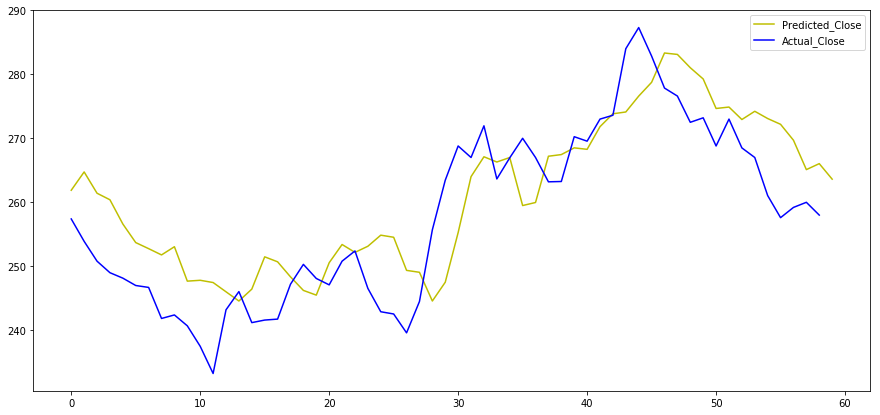

In [75]:
plt.figure(figsize=(15,7))
plt.plot(predict_close,c='y')
plt.plot(y_test.tolist(),c='b')
plt.legend(['Predicted_Close','Actual_Close'])
plt.show()

### <span style="color:brown"> Conculsion

As, you can see the model makes a prediciton that looks lagging in nature. To make the algorithm more accurate we will have to optimize the various hyper parameters used in the model. 

We will look at how to tune these hyper parameters using GridSearch in the next section.